In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs

np.random.seed(3)
%matplotlib inline

plot_size   = 15
plot_width  = 16
plot_height = 8

params = {'legend.fontsize': 'large',
          'figure.figsize': (plot_width,plot_height),
          'axes.labelsize': plot_size,
          'axes.titlesize': plot_size,
          'xtick.labelsize': plot_size*0.75,
          'ytick.labelsize': plot_size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)
plt.rcParams.update(params)

In [2]:
num_cities = 21
num_clients = num_cities - 1
num_vehicles = 4
vehicle_payload = 7

In [3]:
center_box = (100, 200)

cities_coord, _ = make_blobs(n_samples=num_cities,
                           centers=2,
                           cluster_std=20,
                           center_box=center_box,
                           random_state = 2)

all_names = [i for i in range(num_cities)]
client_names = [i for i in range(1, num_cities)]
all_coord_dict = {name: coord for name,coord in zip(all_names, cities_coord)}
client_coord_dict = {name: coord for name,coord in zip(client_names, cities_coord[1:])}

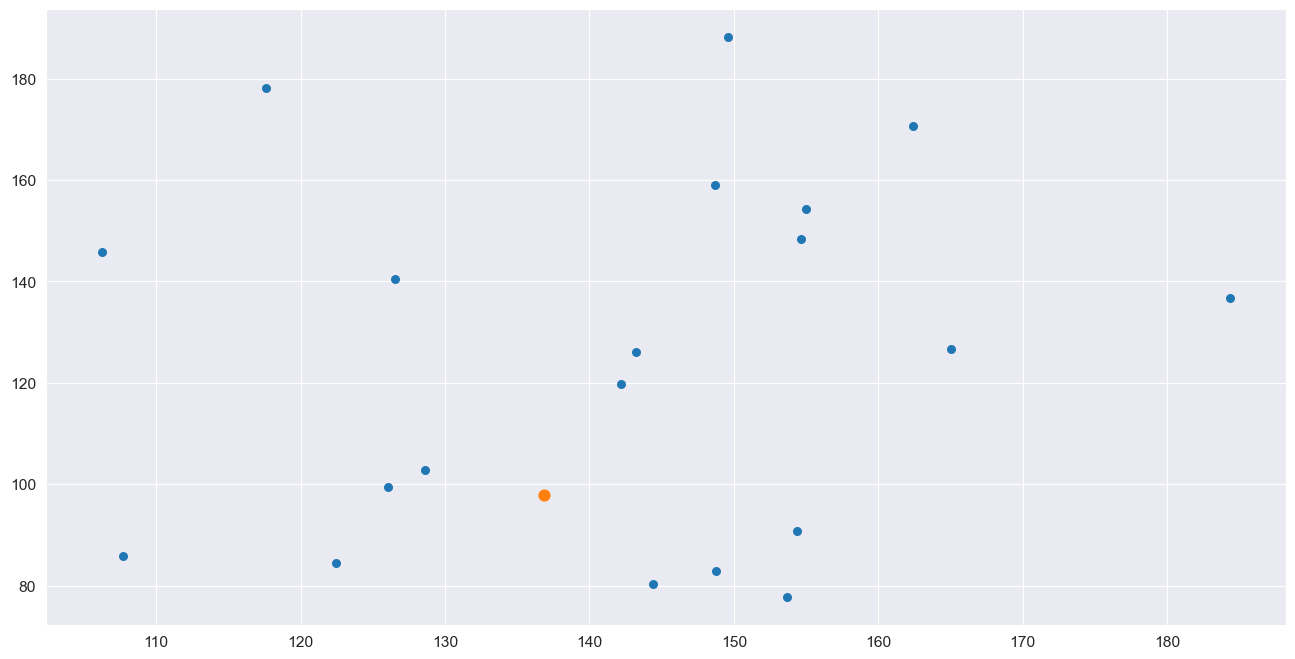

In [4]:
plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2)
plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4)
plt.show()

In [5]:
from scipy.spatial import distance

dist_matrix = distance.cdist(cities_coord, cities_coord, 'euclidean')

In [7]:
from deap import base, creator, tools

In [8]:
tb = base.Toolbox()
creator.create("Fitness_Func", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.Fitness_Func)

In [10]:
from scipy.spatial import distance

dist_matrix = distance.cdist(cities_coord, cities_coord, 'euclidean')


In [19]:
import random
import copy
def chrome_create(_cities_name):
    schedule = copy.deepcopy(_cities_name)
    vehicle = list(np.random.randint(num_vehicles, size=len(schedule)))
    np.random.shuffle(vehicle)
    chromo = [schedule, vehicle]
    return chromo
def chrome_evaluate(_dist_matrix, _chromo):
    route_set = [[] for _ in range(num_vehicles)]
    for s,v in zip(_chromo[0], _chromo[1]):
        route_set[v].append(s)

    dist = 0
    for route in route_set:
        dist += calc_route_cost(_dist_matrix, route)
    return dist,
def get_route(_chromo):
    route_set = [[] for _ in range(num_vehicles)]
    for s, v in zip(_chromo[0], _chromo[1]):
        route_set[v].append(s)
    return route_set
def calc_route_cost(_dist_matrix, _route):
    if not _route:
        return 0
    dist = dist_matrix[_route[-1], 0] + dist_matrix[_route[0], _route[0]]

    for p in range(len(_route) - 1):
        _i = _route[p]
        _j = _route[p + 1]
        dist += _dist_matrix[_i, _j]
    return dist
def crossover(_chromo1, _chromo2):
    cuts = get_chromo_cut()
    partial_crossover(_chromo1[0], _chromo2[0], cuts)

    cuts1 = get_chromo_cut()
    cuts2 = get_chromo_cut(cuts1[2])

    swap_genes(_chromo1[1], _chromo2[1], cuts1, cuts2)


def partial_crossover(_chromo1, _chromo2, cuts):

    size = len(_chromo1)
    p1, p2 = [0] * size, [0] * size

    for i in range(size):
        p1[_chromo1[i] - 1] = i
        p2[_chromo2[i] - 1] = i

    for i in range(cuts[0], cuts[1]):

        temp1 = _chromo1[i] - 1
        temp2 = _chromo2[i] - 1

        _chromo1[i], _chromo1[p1[temp2]] = temp2 + 1, temp1 + 1
        _chromo2[i], _chromo2[p2[temp1]] = temp1 + 1, temp2 + 1

        p1[temp1], p1[temp2] = p1[temp2], p1[temp1]
        p2[temp1], p2[temp2] = p2[temp2], p2[temp1]


def get_chromo_cut(cut_range=None, mutation=False):

    if mutation:
        randrange = num_clients
    else:
        randrange = num_clients + 1

    if cut_range is None:
        cut1 = random.randrange(randrange)
        cut2 = random.randrange(randrange)
        if cut1 > cut2:
            tmp = cut2
            cut2 = cut1
            cut1 = tmp
        cut_range = cut2 - cut1
    else:

        cut1 = random.randrange(num_clients + 1 - cut_range)
        cut2 = cut1 + cut_range
    return cut1, cut2, cut_range


def swap_genes(chrom1, chrom2, cuts1, cuts2):
    tmp = chrom1[cuts1[0]:cuts1[1]]
    chrom1[cuts1[0]:cuts1[1]] = chrom2[cuts2[0]:cuts2[1]]
    chrom2[cuts2[0]:cuts2[1]] = tmp

In [12]:
def mutation(_chromo):
    if np.random.rand() < 0.5:
        swap_gene(_chromo)
    else:
        shuffle_gene(_chromo)


def swap_gene(_chromo):
    cuts = get_chromo_cut(mutation=True)

    if np.random.rand() < 0.5:
        tmp = _chromo[0][cuts[0]]
        _chromo[0][cuts[0]] = _chromo[0][cuts[1]]
        _chromo[0][cuts[1]] = tmp
    else:
        tmp = _chromo[1][cuts[0]]
        _chromo[1][cuts[0]] = _chromo[1][cuts[1]]
        _chromo[1][cuts[1]] = tmp


def shuffle_gene(_chromo):
    cuts = get_chromo_cut(mutation=True)

    if np.random.rand() < 0.5:
        tmp = _chromo[0][cuts[0]:cuts[1]]
        np.random.shuffle(tmp)
        _chromo[0][cuts[0]:cuts[1]] = tmp
    else:
        tmp = _chromo[1][cuts[0]:cuts[1]]
        np.random.shuffle(tmp)
        _chromo[1][cuts[0]:cuts[1]] = tmp

In [13]:
def feasibility(_chromo):
    excess_payload = [vehicle_payload - _chromo[1].count(i) for i in range(num_vehicles)]
    _vehicle_id = [i for i in range(num_vehicles)]

    while any(_p < 0 for _p in excess_payload):
        v_id = next(i for i,_p in enumerate(excess_payload) if _p < 0)
        available_vehicles = [i for i,e in enumerate(excess_payload) if e > 0]

        if len(available_vehicles) == 0:
            raise('INFEASIBLE SOLUTION: No available vehicle to accept excess cargo. Increase the number of vehicles or the vehcile payload')

        idx = [i for i, x in enumerate(_chromo[1]) if x == v_id]
        to_vehicle = random.choice(available_vehicles)
        idx_to_move = random.choice(idx)
        _chromo[1][idx_to_move] = to_vehicle
        excess_payload[v_id] += 1
        excess_payload[to_vehicle] -= 1

In [14]:
tb.register('indexes', chrome_create, client_names)
tb.register('individual', tools.initIterate, creator.Individual, tb.indexes)
tb.register('population', tools.initRepeat, list, tb.individual)
tb.register('evaluate', chrome_evaluate, dist_matrix)
tb.register('select', tools.selTournament)
tb.register('mate', crossover)
tb.register('mutate', mutation)
tb.register('feasibility', feasibility)

In [15]:
num_population = 200
num_generations = 1000
prob_crossover = .4
prob_mutation = .6

In [16]:
population = tb.population(n=num_population)
fitness_set = list(tb.map(tb.evaluate, population))
for ind, fit in zip(population, fitness_set):
    ind.fitness.values = fit

In [17]:
best_fit_list = []
best_sol_list = []

best_fit = np.Inf

for gen in range(0, num_generations):

    if (gen % 50 == 0):
        print(f'Generation: {gen:4} | Fitness: {best_fit:.2f}' )

    offspring = tb.select(population, len(population), tournsize=3)
    offspring = list(map(tb.clone, offspring))

    for child1, child2 in zip(offspring[0::2], offspring[1::2]):
        if np.random.random() < prob_crossover:
            tb.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for chromo in offspring:
        if np.random.random() < prob_mutation:
            tb.mutate(chromo)
            del chromo.fitness.values

    for chromo in offspring:
        tb.feasibility(chromo)

    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitness_set = map(tb.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitness_set):
        ind.fitness.values = fit

    population[:] = offspring

    curr_best_sol = tools.selBest(population, 1)[0]
    curr_best_fit = curr_best_sol.fitness.values[0]

    if curr_best_fit < best_fit:
        best_sol = curr_best_sol
        best_fit = curr_best_fit

    best_fit_list.append(best_fit)
    best_sol_list.append(best_sol)

Generation:    0 | Fitness: inf
Generation:   50 | Fitness: 536.66
Generation:  100 | Fitness: 455.88
Generation:  150 | Fitness: 455.88
Generation:  200 | Fitness: 455.88
Generation:  250 | Fitness: 455.88
Generation:  300 | Fitness: 455.88
Generation:  350 | Fitness: 455.48
Generation:  400 | Fitness: 455.48
Generation:  450 | Fitness: 455.48
Generation:  500 | Fitness: 437.62
Generation:  550 | Fitness: 424.07
Generation:  600 | Fitness: 405.69
Generation:  650 | Fitness: 404.25
Generation:  700 | Fitness: 387.05
Generation:  750 | Fitness: 385.16
Generation:  800 | Fitness: 384.14
Generation:  850 | Fitness: 384.14
Generation:  900 | Fitness: 384.14
Generation:  950 | Fitness: 382.25


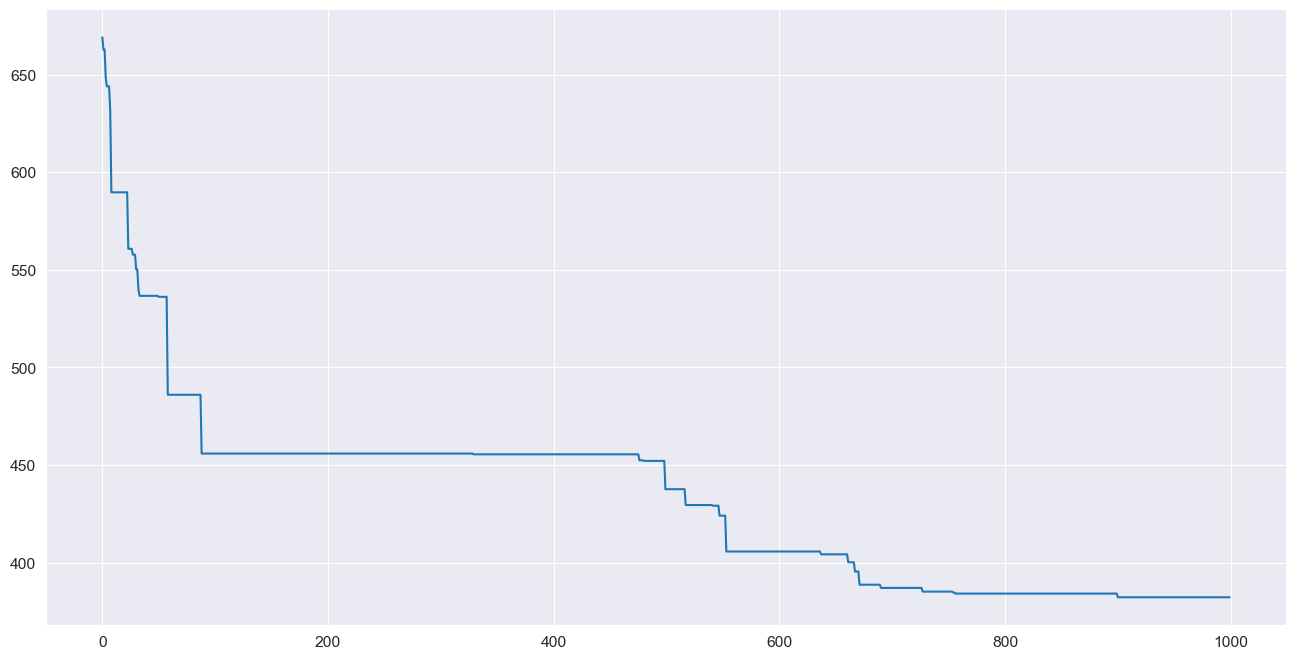

In [18]:
plt.plot(best_fit_list)
plt.show()

In [20]:
best_routes = get_route(best_sol)
print(best_routes)

[[20, 17, 11, 16, 8, 1], [], [6, 13, 18, 9, 2, 4, 15], [10, 7, 14, 12, 5, 19, 3]]


/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_18723/2782023099.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis');
/var/folders/j0/tr2332417vjbmj74tfc0dcd40000gn/T/ipykernel_18723/2782023099.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis');


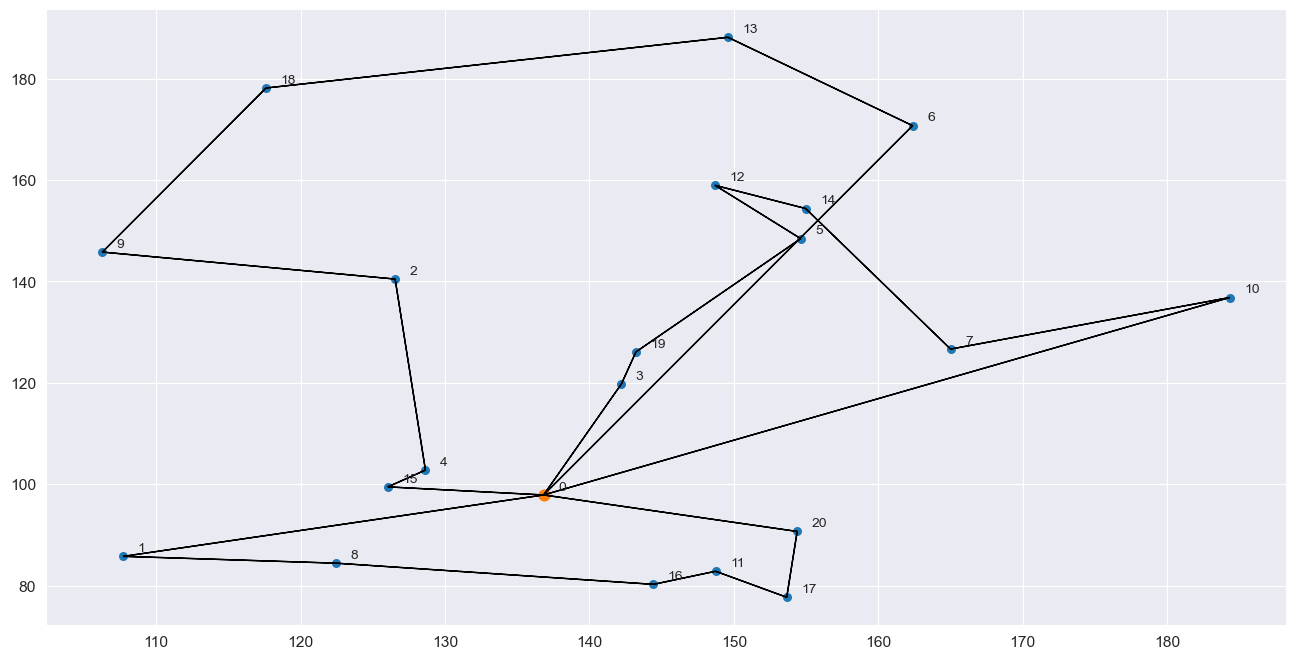

In [21]:
plt.scatter(cities_coord[1:, 0], cities_coord[1:, 1], s=plot_size*2, cmap='viridis');
plt.scatter(cities_coord[0, 0], cities_coord[0, 1], s=plot_size*4, cmap='viridis');
for i, txt in enumerate(all_names):
    plt.annotate(txt, (cities_coord[i, 0]+1, cities_coord[i, 1]+1))

for r in best_routes:
    route = [0] + r + [0]
    for p in range(len(route) - 1):
        i = route[p]
        j = route[p + 1]
        colour = 'black'
        plt.arrow(cities_coord[i][0],
                  cities_coord[i][1],
                  cities_coord[j][0] - cities_coord[i][0],
                  cities_coord[j][1] - cities_coord[i][1],
                  color=colour)

plt.show()